Importing Dependencies

In [1]:
!pip3 install --upgrade pip

  Using cached pip-22.2.2-py3-none-any.whl (2.0 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4


In [6]:
!pip3 install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.5/228.5 MB 1.7 MB/s eta 0:00:0000:0100:04
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.4 MB/s eta 0:00:0000:0100:01
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.1 MB/s eta 0:00:0000:0100:01
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 2.4 MB/s eta 0:00:0000:01
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Preparing metadata (setup.py) ... done
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cac

In [3]:
!pip3 install opencv-python matplotlib

  Using cached opencv_python-4.6.0.66-cp36-abi3-macosx_10_15_x86_64.whl (46.4 MB)


In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [18]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [19]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

In [ ]:
POS_PATH

Collecting data

In [ ]:
#http://vis-www.cs.umass.edu/lfw/
!tar -xf lfw.tar

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [12]:
import uuid

In [20]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [16]:
frame.shape

(250, 250, 3)

Load and Preprocess image

In [25]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(200)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(200)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(200)

In [26]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data/anchor/a2179d40-14c9-11ed-9f28-acde48001122.jpg'


In [27]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [28]:
img = preprocess('data/anchor/a2179d40-14c9-11ed-9f28-acde48001122.jpg')

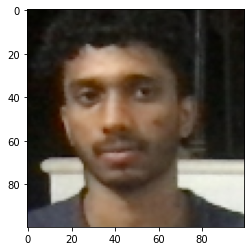

In [30]:
plt.imshow(img)

In [31]:
#creating positive and negative classes
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [32]:
samples = data.as_numpy_iterator()

In [36]:
#positive and negative classes look like this
example = samples.next()

Train and Test partition

In [37]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [38]:
res = preprocess_twin(*example)

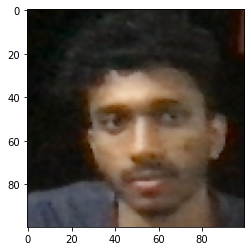

In [39]:
plt.imshow(res[0])

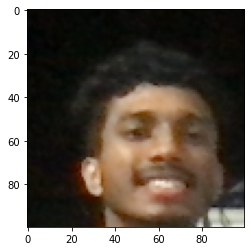

In [40]:
plt.imshow(res[1])

In [43]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

TypeError: in user code:

    File "/var/folders/r7/gsmc7wxj3dqg05vpsdj97_l00000gn/T/ipykernel_23034/3087020015.py", line 2, in preprocess_twin  *
        return(preprocess(input_img), preprocess(validation_img), label)
    File "/var/folders/r7/gsmc7wxj3dqg05vpsdj97_l00000gn/T/ipykernel_23034/788527913.py", line 4, in preprocess  *
        byte_img = tf.io.read_file(file_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [44]:
samples = data.as_numpy_iterator()

In [45]:
samples.next()

(array([[[0.03235294, 0.04411765, 0.01666667],
         [0.02745098, 0.03921569, 0.01176471],
         [0.03137255, 0.04313726, 0.01568628],
         ...,
         [0.02720588, 0.03504902, 0.02328431],
         [0.02352941, 0.03137255, 0.01960784],
         [0.00784314, 0.02745098, 0.01176471]],
 
        [[0.03897059, 0.04289216, 0.02328431],
         [0.04068628, 0.04534314, 0.02573529],
         [0.03235294, 0.03848039, 0.02107843],
         ...,
         [0.03137255, 0.03921569, 0.02941176],
         [0.03137255, 0.03921569, 0.02941176],
         [0.02156863, 0.04019608, 0.02745098]],
 
        [[0.0379902 , 0.03602941, 0.0252451 ],
         [0.03529412, 0.03627451, 0.0254902 ],
         [0.02843137, 0.02867647, 0.02009804],
         ...,
         [0.03529412, 0.04313726, 0.03921569],
         [0.03529412, 0.04313726, 0.03921569],
         [0.03431373, 0.05      , 0.04607843]],
 
        ...,
 
        [[0.15416667, 0.18357843, 0.22769608],
         [0.15686275, 0.18651961, 0.22794

In [46]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [47]:
train_sample= train_data.as_numpy_iterator().next()

In [50]:
len(train_sample[0])

16

In [51]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

Building the deep model

In [52]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [53]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [54]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [55]:
l1 = L1Dist()

In [57]:
#l1(anchor_embedding, validation_embedding)

Making siamese model

In [58]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [60]:
siamese_model = make_siamese_model()

In [61]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [62]:
#setting up loss function and optimiser
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [63]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [64]:
#establishing check points
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [65]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [66]:
from tensorflow.keras.metrics import Precision, Recall

In [67]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

Training the model

In [68]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
17/17 [==============================] - 107s 6s/step
0.2308957 0.6439394 1.0

 Epoch 2/50
17/17 [==============================] - 107s 6s/step
0.041267645 0.9318182 0.9919355

 Epoch 3/50
17/17 [==============================] - 104s 6s/step
0.011114665 0.95454544 1.0

 Epoch 4/50
17/17 [==============================] - 101s 6s/step
0.0028581896 0.984375 0.992126

 Epoch 5/50
17/17 [==============================] - 101s 6s/step
0.01785906 1.0 1.0

 Epoch 6/50
17/17 [==============================] - 101s 6s/step
0.0012923355 0.99270076 1.0

 Epoch 7/50
17/17 [==============================] - 100s 6s/step
0.15025143 0.992126 1.0

 Epoch 8/50
17/17 [==============================] - 101s 6s/step
0.01798165 1.0 1.0

 Epoch 9/50
1/1 [==============================] - 1s 1s/step


17/17 [==============================] - 100s 6s/step
0.13719867 1.0 0.9856115

 Epoch 10/50
17/17 [==============================] - 101s 6s/step
0.113719076 1.0 1.0

 Epoch 11/50
17/17 [==============================] - 102s 6s/step
0.0008559296 1.0 1.0

 Epoch 12/50
17/17 [==============================] - 101s 6s/step
0.011040067 1.0 1.0

 Epoch 13/50
17/17 [==============================] - 729s 45s/step
0.006885718 1.0 1.0

 Epoch 14/50
17/17 [==============================] - 120s 7s/step
0.00077210326 1.0 1.0

 Epoch 15/50
17/17 [==============================] - 117s 7s/step
0.00028206603 1.0 1.0

 Epoch 16/50
17/17 [==============================] - 119s 7s/step
1.0609652e-06 1.0 1.0

 Epoch 17/50
1/1 [==============================] - 1s 1s/step


17/17 [==============================] - 120s 7s/step
3.043058e-05 1.0 1.0

 Epoch 18/50
17/17 [==============================] - 119s 7s/step
0.0002863538 1.0 1.0

 Epoch 19/50
17/17 [==============================] - 119s 7s/step
0.00018224494 1.0 1.0

 Epoch 20/50
17/17 [==============================] - 118s 7s/step
0.00017438373 1.0 1.0

 Epoch 21/50
17/17 [==============================] - 118s 7s/step
0.0006253982 1.0 1.0

 Epoch 22/50
17/17 [==============================] - 116s 7s/step
0.00012995029 1.0 1.0

 Epoch 23/50
17/17 [==============================] - 117s 7s/step
0.00044614045 1.0 1.0

 Epoch 24/50
17/17 [==============================] - 117s 7s/step
3.1829127e-06 1.0 1.0

 Epoch 25/50
17/17 [==============================] - 117s 7s/step
5.0060098e-05 1.0 1.0

 Epoch 26/50
1/1 [==============================] - 1s 1s/step


17/17 [==============================] - 116s 7s/step
0.00046005158 1.0 1.0

 Epoch 27/50
17/17 [==============================] - 115s 7s/step
2.7895155e-06 1.0 1.0

 Epoch 28/50
17/17 [==============================] - 124s 7s/step
0.00026019543 1.0 1.0

 Epoch 29/50
17/17 [==============================] - 127s 7s/step
0.0001387025 1.0 1.0

 Epoch 30/50
17/17 [==============================] - 140s 8s/step
1.8437779e-06 1.0 1.0

 Epoch 31/50
17/17 [==============================] - 139s 8s/step
8.08456e-05 1.0 1.0

 Epoch 32/50
17/17 [==============================] - 139s 8s/step
2.8144139e-05 1.0 1.0

 Epoch 33/50
17/17 [==============================] - 128s 8s/step
0.0003234989 1.0 1.0

 Epoch 34/50
17/17 [==============================] - 137s 8s/step
5.0784715e-06 1.0 1.0

 Epoch 35/50


17/17 [==============================] - 137s 8s/step
0.00012287326 1.0 1.0

 Epoch 36/50
17/17 [==============================] - 140s 8s/step
1.7882665e-05 1.0 1.0

 Epoch 37/50
17/17 [==============================] - 140s 8s/step
1.2517015e-06 1.0 1.0

 Epoch 38/50
17/17 [==============================] - 138s 8s/step
5.9342252e-05 1.0 1.0

 Epoch 39/50
17/17 [==============================] - 143s 8s/step
1.5259771e-05 1.0 1.0

 Epoch 40/50
17/17 [==============================] - 137s 8s/step
1.4127477e-05 1.0 1.0

 Epoch 41/50
17/17 [==============================] - 145s 9s/step
1.8053825e-05 1.0 1.0

 Epoch 42/50
17/17 [==============================] - 138s 8s/step
6.784666e-05 1.0 1.0

 Epoch 43/50
1/1 [==============================] - 1s 1s/step


17/17 [==============================] - 139s 8s/step
0.00014478712 1.0 1.0

 Epoch 44/50
17/17 [==============================] - 149s 9s/step
0.00020329357 1.0 1.0

 Epoch 45/50
17/17 [==============================] - 129s 8s/step
2.6377846e-05 1.0 1.0

 Epoch 46/50
17/17 [==============================] - 127s 7s/step
2.3126186e-05 1.0 1.0

 Epoch 47/50
17/17 [==============================] - 126s 7s/step
2.2390966e-05 1.0 1.0

 Epoch 48/50
17/17 [==============================] - 126s 7s/step
1.8960185e-05 1.0 1.0

 Epoch 49/50
17/17 [==============================] - 126s 7s/step
2.972531e-05 1.0 1.0

 Epoch 50/50
17/17 [==============================] - 127s 8s/step
3.5473186e-05 1.0 1.0


In [69]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [70]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 1s/step


In [71]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]

In [72]:
y_true

array([1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.],
      dtype=float32)

Calculating metrics

In [73]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [74]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

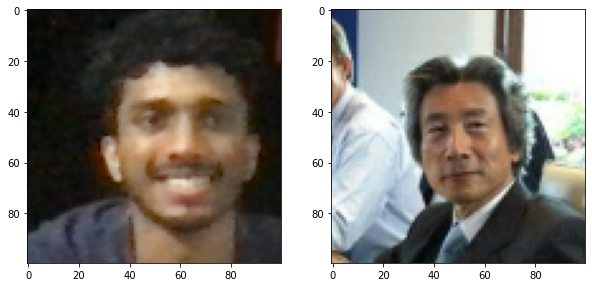

In [76]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

In [77]:
siamese_model.save('siamesemodelv2.h5')

In [78]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [79]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 1s/step


array([[9.9990654e-01],
       [8.4374437e-07],
       [1.0000000e+00],
       [1.3857859e-07],
       [9.9910593e-01],
       [8.8597778e-09],
       [9.9999988e-01],
       [2.0071965e-08],
       [4.3648047e-08],
       [1.6851011e-08],
       [3.4651927e-07],
       [1.0000000e+00],
       [9.9994743e-01],
       [7.8051109e-08],
       [1.0000000e+00],
       [6.6630323e-10]], dtype=float32)

In [80]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

Real time verification

In [82]:
os.listdir(os.path.join('application_data', 'verification_images'))

['2acfd980-14cb-11ed-9f28-acde48001122.jpg',
 '4a461aaa-14ca-11ed-9f28-acde48001122.jpg',
 '733354d6-14cb-11ed-9f28-acde48001122.jpg',
 '2c4340e0-14cb-11ed-9f28-acde48001122.jpg',
 '67b34878-14cb-11ed-9f28-acde48001122.jpg',
 '1ef94d9e-14cb-11ed-9f28-acde48001122.jpg',
 '310726f0-14cb-11ed-9f28-acde48001122.jpg',
 '436624ea-14cb-11ed-9f28-acde48001122.jpg',
 '67e6a768-14cb-11ed-9f28-acde48001122.jpg',
 '67cd8de6-14cb-11ed-9f28-acde48001122.jpg',
 '291005e8-14cb-11ed-9f28-acde48001122.jpg',
 '66c011a8-14cb-11ed-9f28-acde48001122.jpg',
 '2a835c22-14cb-11ed-9f28-acde48001122.jpg',
 '2c5bea46-14cb-11ed-9f28-acde48001122.jpg',
 '66d9058c-14cb-11ed-9f28-acde48001122.jpg',
 '4666503e-14cb-11ed-9f28-acde48001122.jpg',
 '1ff7f808-14cb-11ed-9f28-acde48001122.jpg',
 '63b5d506-14cb-11ed-9f28-acde48001122.jpg',
 '1f5ef70c-14cb-11ed-9f28-acde48001122.jpg',
 '2fc65cde-14cb-11ed-9f28-acde48001122.jpg',
 '64c86382-14cb-11ed-9f28-acde48001122.jpg',
 '68f4605a-14cb-11ed-9f28-acde48001122.jpg',
 'b8fe70e6

In [83]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [85]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 152ms/step
False
1/1 [==============================] - 0s 139ms/step
True
1/1 [==============================] - 0s 144ms/step
True
